In [1]:
!nvidia-smi 

Sun May 10 12:38:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 32%   53C    P0    65W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 34%   54C    P0    68W / 250W |      0MiB / 11019MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
'''# For clean

import os
import fnmatch
 
INTERNAL_DATA_PATH = 'cropped_coco/'
# Get a list of all files in directory
for rootDir, subdirs, filenames in os.walk(INTERNAL_DATA_PATH):
    # Find the files that matches the given patterm
    for filename in fnmatch.filter(filenames, '.*'):
        try:
            #print(filename)
            os.remove(os.path.join(rootDir, filename))
        except OSError:
            print("Error while deleting file")
    for subdir in fnmatch.filter(subdirs, '.*'):
        try:
            #print(filename)
            os.remove(os.path.join(rootDir, subdir))
        except OSError:
            print("Error while deleting file")'''

'# For clean\n\nimport os\nimport fnmatch\n \nINTERNAL_DATA_PATH = \'cropped_coco/\'\n# Get a list of all files in directory\nfor rootDir, subdirs, filenames in os.walk(INTERNAL_DATA_PATH):\n    # Find the files that matches the given patterm\n    for filename in fnmatch.filter(filenames, \'.*\'):\n        try:\n            #print(filename)\n            os.remove(os.path.join(rootDir, filename))\n        except OSError:\n            print("Error while deleting file")\n    for subdir in fnmatch.filter(subdirs, \'.*\'):\n        try:\n            #print(filename)\n            os.remove(os.path.join(rootDir, subdir))\n        except OSError:\n            print("Error while deleting file")'

In [3]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


########################################################################
batch_size = 4
########################################################################


In [4]:
DATASET_PATH = 'sampled_cropped_coco'
TRAIN_PATH = DATASET_PATH + '/train/100'
TEST_PATH = DATASET_PATH + '/val/50'

In [5]:
#img_size = [729,243,81,27,9]  

from torch.utils.data.sampler import SubsetRandomSampler

default_transform = transforms.Compose(
    [transforms.Resize((224,224)),
    transforms.ToTensor()])

trainCocoDataset = datasets.ImageFolder(root=TRAIN_PATH,transform = default_transform)
testCocoDataset = datasets.ImageFolder(root=TEST_PATH,transform = default_transform)

#subset_indices = [x for x in range(10000)]

trainloader = torch.utils.data.DataLoader(trainCocoDataset,
                                          batch_size = batch_size, 
                                          shuffle=True,
                                         num_workers=4)
                                         #sampler=SubsetRandomSampler(subset_indices))

testloader = torch.utils.data.DataLoader(testCocoDataset,
                                          batch_size = batch_size, 
                                          shuffle=True,
                                        num_workers=4)#,
                                        #sampler=SubsetRandomSampler(subset_indices))


In [6]:
'''trainCocoDataset.class_to_idx'''

'trainCocoDataset.class_to_idx'

In [7]:
from SCResnet import SCResNet50,ResNet50
from torchvision.models import resnet50
from torchvision.models.detection import fasterrcnn_resnet50_fpn


In [8]:
from torch.nn.parallel.data_parallel import DataParallel
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '29500'
dist.init_process_group(backend='nccl',rank=0,world_size=1)

In [9]:
device = 'cuda:3'
num_classes = 80
#model1 = resnet50(num_classes=80).to(device)
#model1 = SCResNet50(num_classes).to(device)
#model1 = fasterrcnn_resnet50_fpn(num_classes=num_classes).to(device)
model1 = fasterrcnn_resnet50_fpn(pretrained=True).to(device)
if torch.cuda.device_count() > 1:
    model1 = DDP(model1,device_ids = [3],find_unused_parameters=True)

In [10]:
import os
from torchvision import transforms

SIZED_VAL_PATH = 'sampled_cropped_coco/val'

val_gen_arr = []
for i in tqdm(range(10,110,10)):
    transform = transforms.Compose(
        [
        transforms.Resize((224,224)),
        transforms.ToTensor()])

    testCocoDataset_val = datasets.ImageFolder(root=os.path.join(SIZED_VAL_PATH,str(i)),transform = transform)

    testloader_val = torch.utils.data.DataLoader(testCocoDataset_val,
                                              batch_size = batch_size, 
                                              shuffle=True,
                                            num_workers=4)
    val_gen_arr.append(testloader_val)


100%|██████████| 10/10 [00:00<00:00, 10.34it/s]


In [11]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

learning_rate = 0.001
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

In [12]:
TEST_RESULT_PATH = 'testresults/'
WEIGHTS_PATH = 'weights/'

TASK_NAME = 'sampled_COCO_fasterrcnn_50'
DATE = '5/10'

In [13]:
def target_generator(label):
    target_list = []
    for i in range(label.shape[0]):
        target = {}
        box_list = []
        label_list = []
        box_list.append([np.float32(0),np.float32(0),np.float32(224),np.float32(224)])
        label_list.append(label[i])
        box_tensor = torch.tensor(box_list).to(device)
        label_tensor = torch.tensor(label_list).to(device)
        target["boxes"] = box_tensor
        target["labels"] = label_tensor
        target_list.append(target)
    return target_list

In [14]:
def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

In [15]:
def tensor_counter(input_tensor):
    return_list = []
    for i in range(len(input_tensor)):
        if len(input_tensor[i]['labels']) == 0:
            return_list.append(-1)
        else:
            temp = input_tensor[i]['labels'][:10].cpu().numpy()
            unique, counts = np.unique(temp, return_counts=True)
            return_list.append(unique[np.where(counts == counts.max())[0][0]])
    return return_list

In [16]:
import torch.optim as optim
import sys
from tqdm import tqdm

temp_dict = testCocoDataset.class_to_idx
temp_dict['-1'] = -1

trn_loss_list = []
val_loss_list = []
acc_list = []
acc_list_aug = []
num_batches = len(trainloader)
for epoch in range(20):
    running_loss = 0.0
    '''model1.train()
    for i,images in tqdm(enumerate(trainloader)):
        optimizer.zero_grad()
        c1 = images[0].to(device)
        c6 = images[1].to(device)
        target = target_generator(c6)
        loss_dict = model1(c1,target)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()
        losses.backward()    # calc gradients
        optimizer.step()   # update gradients
        running_loss += loss_value'''
    
    model1.eval()
    with torch.no_grad(): # very very very very important!!!
        val_loss = 0.0
        class_correct = list(0. for i in range(num_classes))
        class_total = list(0. for i in range(num_classes))
        correct = 0
        total = 0
        for j,val in tqdm(enumerate(testloader),total=len(testloader)):
            v1 = val[0].to(device)
            val_labels = val[1].to(device)
            val_output = model1(v1)
            val_output = [temp_dict[str(tensor_counter(val_output)[x])] for x in range(len(val_output))]
            c = (val_output == val_labels.cpu().numpy()).squeeze()
            total += val_labels.size(0)
            correct += (val_output == val_labels.cpu().numpy()).sum()
            for i in range(len(val_labels)):
                val_label = val_labels[i]
                class_correct[val_label] += c[i]
                class_total[val_label] += 1

        print("epoch:",str(epoch),str(i)," batch")
        for i in range(num_classes):
            if class_total[i]==0:
                print('class_total = 0',class_correct,class_total)
            else:
                print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

    print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
        epoch+1, 20, i+1, num_batches, running_loss / len(trainloader), val_loss / len(testloader)
    ))        
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

    trn_loss_list.append(running_loss/1875)
    val_loss_list.append(val_loss/len(testloader))
    running_loss = 0.0

    '''if epoch == 9:
        optimizer = optim.Adam(model1.parameters(), lr=0.0001)
        print('lr is changed to 0.0001')'''
        
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)'''
    

100%|██████████| 8401/8401 [19:41<00:00,  7.11it/s]

epoch: 0 3  batch
Accuracy of     0 : 82 %
class_total = 0 [9088.0, 0.0, 0.0, 0.0, 0.0, 111.0, 274.0, 52.0, 59.0, 105.0, 77.0, 291.0, 289.0, 183.0, 0.0, 241.0, 195.0, 20.0, 118.0, 1176.0, 15.0, 35.0, 121.0, 0.0, 78.0, 0.0, 0.0, 173.0, 0.0, 130.0, 0.0, 31.0, 105.0, 25.0, 486.0, 61.0, 203.0, 22.0, 44.0, 84.0, 22.0, 154.0, 243.0, 69.0, 45.0, 128.0, 249.0, 254.0, 0.0, 69.0, 55.0, 231.0, 106.0, 535.0, 34.0, 118.0, 38.0, 28.0, 75.0, 81.0, 40.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 96.0, 0.0, 90.0, 0.0, 794.0, 0.0, 81.0, 0.0, 89.0, 0.0, 285.0, 0.0] [11004.0, 0.0, 0.0, 0.0, 0.0, 413.0, 440.0, 202.0, 218.0, 273.0, 316.0, 361.0, 380.0, 255.0, 0.0, 268.0, 232.0, 371.0, 413.0, 1932.0, 540.0, 254.0, 303.0, 0.0, 241.0, 0.0, 0.0, 336.0, 0.0, 371.0, 0.0, 179.0, 269.0, 225.0, 1025.0, 343.0, 899.0, 215.0, 326.0, 143.0, 253.0, 626.0, 379.0, 239.0, 177.0, 287.0, 316.0, 371.0, 0.0, 285.0, 285.0, 338.0, 316.0, 1791.0, 261.0, 343.0, 163.0, 697.0, 190.0, 179.0, 288.0, 231.0, 0.0, 0.0, 0.0, 0.0, 0.0, 143.0, 41


  3%|▎         | 262/8401 [00:36<19:08,  7.09it/s]

KeyboardInterrupt: 

In [26]:
num = 0
acc_list = []
for i in range(len(class_correct)):
    if class_total[i] != 0:
        print(i,class_correct[i]/class_total[i])
        acc_list.append(class_correct[i]/class_total[i])
        num+=1
print(num)

0 0.8323170731707317
5 0.15384615384615385
6 0.6153846153846154
7 0.16666666666666666
8 0.0
9 0.5
10 0.375
11 0.9333333333333333
12 0.8571428571428571
13 0.7142857142857143
15 1.0
16 0.8571428571428571
17 0.1
18 0.0
19 0.6346153846153846
20 0.0
21 0.1
22 0.2857142857142857
24 0.2727272727272727
27 0.38461538461538464
29 0.36363636363636365
31 0.0
32 0.3333333333333333
33 0.2
34 0.4878048780487805
35 0.07142857142857142
36 0.3548387096774194
37 0.21428571428571427
38 0.25
39 0.5
40 0.14285714285714285
41 0.21052631578947367
42 0.5833333333333334
43 0.2
44 0.8333333333333334
45 0.375
46 1.0
47 0.6
49 0.14285714285714285
50 0.0
51 0.7142857142857143
52 0.3333333333333333
53 0.25
54 0.0
55 0.3888888888888889
56 0.75
57 0.0
58 0.25
59 0.5
60 0.0
61 0.2222222222222222
67 0.0
68 0.3157894736842105
70 0.4444444444444444
72 0.7708333333333334
74 0.16666666666666666
76 0.5
78 0.625
58


In [28]:
np.array(acc_list).mean()

0.3771981123118048

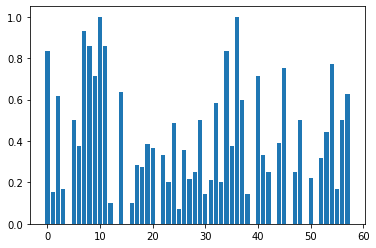

In [31]:
import matplotlib.pyplot as plt
plt.bar(range(58),acc_list)
plt.show()

In [115]:
unique, counts = np.unique(val_output[1]['labels'][:10].cpu().numpy(), return_counts=True)
unique[np.where(counts == counts.max())[0][0]]

ValueError: zero-size array to reduction operation maximum which has no identity

In [104]:
tensor_counter(val_output)

ValueError: zero-size array to reduction operation maximum which has no identity

In [96]:
val_output_test = [testCocoDataset.class_to_idx[str(tensor_counter(val_output)[x])] for x in range(len(val_output))]

In [80]:
val_labels

tensor([ 0, 51,  0, 50], device='cuda:3')

In [98]:
c = (val_output_test == val_labels.cpu().numpy()).squeeze()

In [100]:
c.sum()

2

In [22]:
temp_dict = testCocoDataset.class_to_idx
temp_dict['-1'] = -1
temp_dict

{'1': 0,
 '10': 1,
 '11': 2,
 '13': 3,
 '14': 4,
 '15': 5,
 '16': 6,
 '17': 7,
 '18': 8,
 '19': 9,
 '2': 10,
 '20': 11,
 '21': 12,
 '22': 13,
 '23': 14,
 '24': 15,
 '25': 16,
 '27': 17,
 '28': 18,
 '3': 19,
 '31': 20,
 '32': 21,
 '33': 22,
 '34': 23,
 '35': 24,
 '36': 25,
 '37': 26,
 '38': 27,
 '39': 28,
 '4': 29,
 '40': 30,
 '41': 31,
 '42': 32,
 '43': 33,
 '44': 34,
 '46': 35,
 '47': 36,
 '48': 37,
 '49': 38,
 '5': 39,
 '50': 40,
 '51': 41,
 '52': 42,
 '53': 43,
 '54': 44,
 '55': 45,
 '56': 46,
 '57': 47,
 '58': 48,
 '59': 49,
 '6': 50,
 '60': 51,
 '61': 52,
 '62': 53,
 '63': 54,
 '64': 55,
 '65': 56,
 '67': 57,
 '7': 58,
 '70': 59,
 '72': 60,
 '73': 61,
 '74': 62,
 '75': 63,
 '76': 64,
 '77': 65,
 '78': 66,
 '79': 67,
 '8': 68,
 '80': 69,
 '81': 70,
 '82': 71,
 '84': 72,
 '85': 73,
 '86': 74,
 '87': 75,
 '88': 76,
 '89': 77,
 '9': 78,
 '90': 79,
 '-1': -1}

In [43]:
testCocoDataset.class_to_idx

0

In [ ]:
for j,val in enumerate(testloader):
    v1 = val[0].to(device)
    val_labels = val[1].to(device)
    val_output = model1(v1)


In [ ]:
for i,images in tqdm(enumerate(trainloader)):
    print(images[1].shape)
    break

# TRAIN AND TEST ENDS
code below won't work